<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>I – Fusion multimodale texte–image</h2>

<p>
Cette partie vise à évaluer l’apport d’une <b>fusion multimodale</b> combinant les
informations textuelles et visuelles pour la classification des produits. Les
expérimentations précédentes ont permis d’identifier et de valider des modèles
performants pour chaque modalité prise séparément, ainsi que des stratégies de
fusion intra-modales robustes.
</p>

<p>
Du côté du texte, un modèle final basé sur un <b>blending pondéré</b> de
<b>CamemBERT-large</b>, <b>XLM-R</b> et de features <b>TF-IDF</b> atteint un
<b>F1-score pondéré de 0.912</b> sur le jeu de test. Côté image, la fusion des
modèles <b>ConvNeXt</b> et <b>Swin Transformer</b> conduit à un modèle visuel
atteignant un <b>F1-score pondéré de 0.763</b>. Ces deux modèles constituent des
bases solides et complémentaires pour une approche multimodale.
</p>

<p>
Afin de garantir la reproductibilité et d’isoler l’impact des stratégies de
fusion multimodales, les <b>probabilités de sortie</b> de ces deux modèles
intra-modaux ont été <b>pré-calculées et sauvegardées</b>. Le présent notebook se
concentre ainsi exclusivement sur l’étude de deux stratégies de fusion finale :
le <b>blending pondéré</b> et le <b>stacking</b>, appliqués aux sorties probabilistes
des modèles texte et image.
</p>

<p>
Cette démarche permet d’analyser de manière contrôlée l’apport réel de
l’information visuelle par rapport au texte, tout en comparant une approche de
fusion simple et contrainte à une stratégie de fusion apprise plus flexible. Les
résultats obtenus serviront à sélectionner la stratégie multimodale finale
retenue pour la suite du projet.
</p>

</div>

In [1]:
import numpy as np
import pandas as pd

import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '../src')
from data import load_data, CATEGORY_SHORT_NAMES, get_image_path
from utils.calibration import fit_temperature, calibrated_probas, normalize_probas, weights_from_logloss

from visualization import plot_classification_report, plot_f1_comparison_with_delta, display_df_with_images

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import HTML

In [2]:
_, X_val, X_test, y_train, y_val, y_test = load_data(splitted=True).values()
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.tolist())
y_val = encoder.transform(y_val.tolist())
y_test = encoder.transform(y_test.tolist())

idx = np.arange(len(y_val))

idx_meta, idx_eval = train_test_split(
    idx,
    test_size=0.30,
    random_state=42,
    stratify=y_val
)

In [3]:
P_val_txt = np.load("../models/fusion/text/proba_text_val.npy")
P_test_txt = np.load("../models/fusion/text/proba_text_test.npy")
P_val_im = np.load("../models/fusion/image/proba_image_val.npy")
P_test_im = np.load("../models/fusion/image/proba_image_test.npy")

In [4]:
# BLENDING MULTIMODAL (TEXTE + IMAGE) AVEC CALCUL DES POIDS

rows = []

# --- Probabilités disponibles ---
probas_mm = {
    "text": normalize_probas(P_val_txt),
    "image": normalize_probas(P_val_im),
}

configs_mm = {
    "texte + image": ["text", "image"],
}

for config_name, models in configs_mm.items():

    log_losses = {
        m: log_loss(y_val, probas_mm[m])
        for m in models
    }

    weights = weights_from_logloss(log_losses)

    P_blend = sum(weights[m] * probas_mm[m] for m in models)
    P_blend = normalize_probas(P_blend)

    y_pred = np.argmax(P_blend, axis=1)

    f1 = f1_score(
        y_val[idx_eval],
        y_pred[idx_eval],
        average="weighted"
    )

    ll = log_loss(
        y_val[idx_eval],
        P_blend[idx_eval]
    )

    rows.append({
        "configuration": f"blending - {config_name}",
        "w_text": weights.get("text", 0.0),
        "w_image": weights.get("image", 0.0),
        "f1_weighted": f1,
        "log_loss": ll,
    })

df_blending_mm = pd.DataFrame(rows).set_index("configuration")



# STACKING MULTIMODAL (TEXTE + IMAGE)

rows = []

for config_name, models in configs_mm.items():

    X_meta = np.concatenate(
        [probas_mm[m] for m in models],
        axis=1
    )

    X_meta_train = X_meta[idx_meta]
    X_meta_eval = X_meta[idx_eval]

    y_train = y_val[idx_meta]
    y_eval = y_val[idx_eval]

    meta_model = LogisticRegression(
        max_iter=3000,
        n_jobs=-1,
    )

    meta_model.fit(X_meta_train, y_train)

    P_eval = meta_model.predict_proba(X_meta_eval)
    P_eval = P_eval / P_eval.sum(axis=1, keepdims=True)

    y_pred = np.argmax(P_eval, axis=1)

    f1 = f1_score(
        y_eval,
        y_pred,
        average="weighted"
    )

    ll = log_loss(
        y_eval,
        P_eval
    )

    rows.append({
        "configuration": f"stacking - {config_name}",
        "f1_weighted": f1,
        "log_loss": ll,
    })

df_stacking_mm = pd.DataFrame(rows).set_index("configuration")


# TABLEAU FINAL

scores_mm = pd.concat(
    [df_blending_mm, df_stacking_mm],
    axis=0
)

scores_mm


,w_text,w_image,f1_weighted,log_loss
configuration,,,,
blending - texte + image,0.726607,0.273393,0.921911,0.359794
stacking - texte + image,NaN,NaN,0.922015,0.296934


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h4>Analyse des résultats de la fusion multimodale</h4>

<p>
Le tableau ci-dessus compare deux stratégies de fusion multimodale appliquées aux
sorties probabilistes des modèles texte et image : un <b>blending pondéré</b> et un
<b>stacking</b> final basé sur un méta-classifieur logistique.
</p>

<p>
La stratégie de <b>blending texte + image</b> atteint un
<b>F1-score pondéré de 0.922</b>, avec un poids majoritaire attribué au texte
(≈&nbsp;0.73), confirmant le rôle prépondérant de l’information textuelle dans la
tâche de classification. La contribution de l’image, bien que plus limitée,
apporte néanmoins un gain mesurable par rapport au modèle texte seul.
</p>

<p>
Le <b>stacking texte + image</b> conduit à un
<b>F1-score pondéré très proche</b> de celui du blending, mais se distingue par une
<b>amélioration marquée de la log loss</b>. Cette baisse significative de la log
loss indique une meilleure calibration des probabilités finales, traduisant une
combinaison plus cohérente et plus prudente des signaux issus des deux modalités.
</p>

<p>
Compte tenu de performances de classification comparables, le
<b>stacking</b> est retenu comme <b>modèle multimodal final</b>. Ce choix est motivé
par la meilleure qualité probabiliste obtenue, critère particulièrement
important dans une logique de fusion multimodale et d’exploitation des scores de
confiance.
</p>

</div>


Intro test et enregistrement du modèle

In [5]:
joblib.dump(meta_model, "../models/fusion/multimodal/meta_model_stacking.joblib")

['../models/fusion/multimodal/meta_model_stacking.joblib']

In [6]:
P_test_txt = normalize_probas(P_test_txt)
P_test_im = normalize_probas(P_test_im)

X_test_meta = np.concatenate(
    [P_test_txt, P_test_im],
    axis=1
)

P_test_final = meta_model.predict_proba(X_test_meta)
P_test_final = P_test_final / P_test_final.sum(axis=1, keepdims=True)

y_test_pred = np.argmax(P_test_final, axis=1)

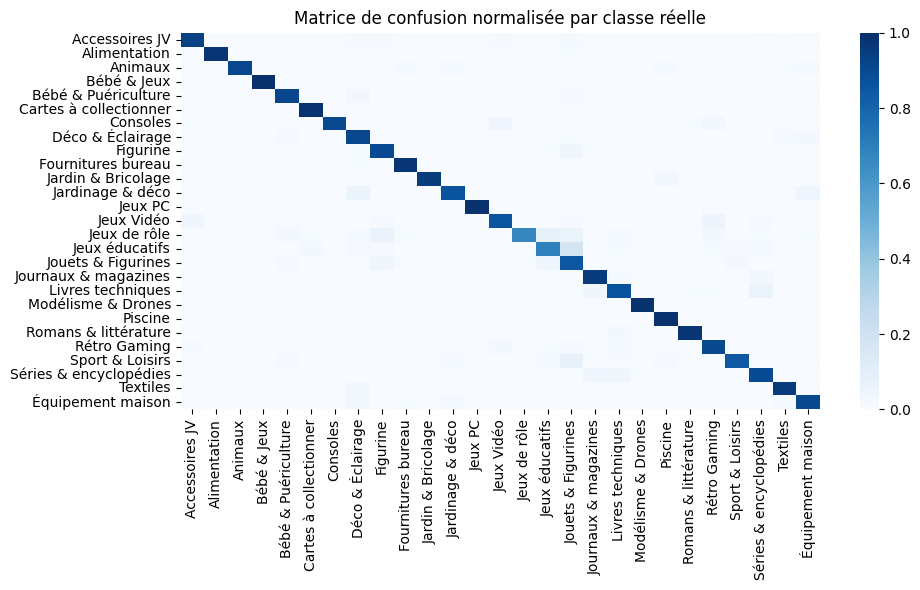


Classes avec les meilleurs scores F1 (top 5)


,precision,recall,f1-score,support
Bébé & Jeux,1.000,1.000,1.000,121.0
Jeux PC,1.000,0.992,0.996,131.0
Modélisme & Drones,0.995,0.992,0.993,757.0
Piscine,0.985,0.993,0.989,1531.0
Cartes à collectionner,0.982,0.988,0.985,593.0



Classes avec les plus faibles scores F1 (bottom 5)


,precision,recall,f1-score,support
Sport & Loisirs,0.895,0.842,0.868,374.0
Livres techniques,0.856,0.867,0.862,467.0
Jouets & Figurines,0.812,0.851,0.831,731.0
Jeux de rôle,0.906,0.670,0.770,115.0
Jeux éducatifs,0.782,0.691,0.734,311.0



Confusions les plus fréquentes (top 5)


,Classe réelle,Classe prédite,% des prédictions de la classe réelle
0,Jeux éducatifs,Jouets & Figurines,18.3
1,Jeux de rôle,Jeux éducatifs,7.8
2,Sport & Loisirs,Jouets & Figurines,7.5
3,Jeux de rôle,Figurine,7.0
4,Jeux de rôle,Jouets & Figurines,6.1


In [7]:
# plot_f1_comparison_with_delta(y_test, y_pred, y_pred_cam, new_name="fusion", ref_name="camembert", encoder=encoder)
plot_classification_report(y_test, y_test_pred, encoder=encoder, k_best_f1=5)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h4>Analyse des performances par classe et des confusions</h4>

<p>
L’analyse détaillée des performances par classe met en évidence une forte
hétérogénéité des scores, reflétant la nature intrinsèque des catégories et la
clarté variable de leurs frontières sémantiques et visuelles.
</p>

<p>
Les classes présentant les <b>meilleurs scores de F1</b> correspondent à des
catégories bien définies, tant du point de vue textuel que visuel. Des classes
comme <b>Bébé &amp; Jeux</b>, <b>Jeux PC</b>, <b>Modélisme &amp; Drones</b>,
<b>Piscine</b> ou <b>Cartes à collectionner</b> atteignent des scores proches de la
perfection. Ces performances s’expliquent par des descriptions produits très
spécifiques, un vocabulaire distinctif et, dans certains cas, des indices
visuels particulièrement discriminants (emballages, formes ou usages clairement
identifiables).
</p>

<p>
À l’inverse, les <b>classes présentant les scores de F1 les plus faibles</b> sont
celles dont les frontières sont plus floues ou qui recouvrent des usages et des
objets hétérogènes. Les catégories <b>Jeux éducatifs</b>, <b>Jeux de rôle</b>,
<b>Jouets &amp; Figurines</b>, <b>Livres techniques</b> et
<b>Sport &amp; Loisirs</b> regroupent des produits aux descriptions souvent
ambiguës, partageant un vocabulaire commun et des thématiques proches, ce qui
limite la séparabilité des classes.
</p>

<p>
L’étude des confusions les plus fréquentes confirme cette interprétation. La
confusion dominante entre <b>Jeux éducatifs</b> et
<b>Jouets &amp; Figurines</b> (18,3&nbsp;% des erreurs de la classe) traduit une
forte proximité sémantique et fonctionnelle entre ces catégories. De même, les
<b>Jeux de rôle</b> sont majoritairement confondus avec
<b>Jeux éducatifs</b> ou <b>Figurine</b>, ce qui reflète des descriptions produits
souvent hybrides, à la frontière entre jeu, apprentissage et collection.
</p>

<p>
Les confusions observées pour la catégorie <b>Sport &amp; Loisirs</b> avec
<b>Jouets &amp; Figurines</b> illustrent quant à elles une limite classique des
approches basées sur le contenu : certaines descriptions mettent davantage en
avant l’aspect ludique ou visuel du produit que son usage sportif réel, induisant
des erreurs cohérentes d’un point de vue métier.
</p>

<p>
Dans l’ensemble, ces résultats montrent que les erreurs du modèle final sont
principalement concentrées sur des <b>zones grises du problème de
classification</b>, où même une annotation humaine peut s’avérer ambiguë. Les
bonnes performances observées sur les classes bien définies et la nature
sémantiquement cohérente des confusions confirment la robustesse du modèle
multimodal retenu.
</p>

<p>
Ces observations suggèrent que des améliorations futures pourraient être obtenues
via un enrichissement contextuel des données (descriptions plus longues,
métadonnées supplémentaires) ou par une exploitation plus fine de l’information
visuelle pour les catégories aux frontières les plus floues.
</p>

</div>


Analyse des feautures importance

In [8]:
coef = meta_model.coef_  # shape (n_classes, 2 * n_classes)

n_classes = coef.shape[1] // 2

coef_text = coef[:, :n_classes]
coef_image = coef[:, n_classes:]

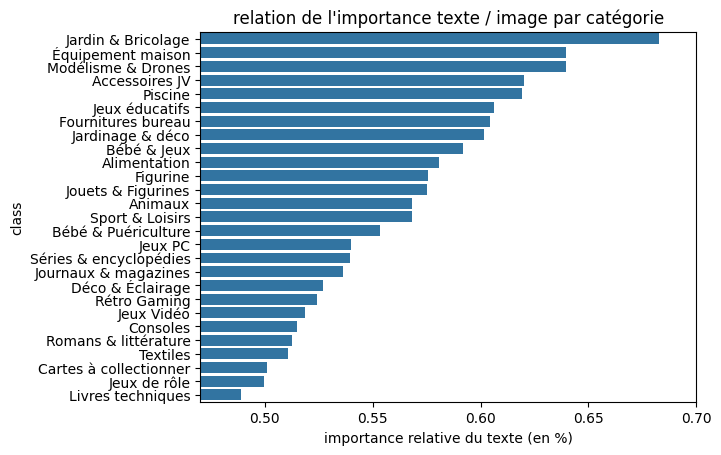

In [49]:
categories = [CATEGORY_SHORT_NAMES[c] for c in encoder.inverse_transform(range(27))]

rows = []

for i, cat in enumerate(categories):
    text_importance = np.mean(np.abs(coef_text[i]))
    image_importance = np.mean(np.abs(coef_image[i]))
    text_importance_rate = text_importance / (text_importance + image_importance)
    
    rows.append({
        "class": cat,
        "text_importance_rate": text_importance_rate,
        "text_importance": text_importance,
        "image_importance": image_importance,
    })
    

df_importance = pd.DataFrame(rows).sort_values("text_importance_rate", ascending=False)


importance_text = np.mean(np.abs(coef_text))
importance_image = np.mean(np.abs(coef_image))

beautiful_print(
    f"importance globale du <b>texte</b> sur l'importance de l'image pour le modèle : <b>{importance_text*100 / (importance_text+importance_image):.2f}% </b>"
)

sns.barplot(data=df_importance, y='class', x='text_importance_rate', orient='h')
plt.xlabel('importance relative du texte (en %)')
plt.title("relation de l'importance texte / image par catégorie")
plt.xlim(0.47,0.7)
plt.show()

<div style="background:#f7fbff; padding:14px; border-radius:6px">

<h4>Analyse de l’importance relative du texte et de l’image</h4>

<p>
Afin de mieux comprendre le fonctionnement du modèle multimodal final, une
analyse de l’<b>importance relative des modalités texte et image</b> a été menée
à partir des coefficients du méta-classifieur de stacking. Cette analyse permet
d’évaluer dans quelle mesure chaque modalité contribue à la décision finale,
tant de manière globale que catégorie par catégorie.
</p>

<p>
À l’échelle globale, le texte représente environ
<b>56,5&nbsp;% de l’importance totale</b>, contre
<b>43,5&nbsp;% pour l’image</b>. Cette répartition confirme que l’information
textuelle constitue la source principale de décision du modèle, tout en montrant
que l’image joue un rôle complémentaire significatif. Ce résultat est cohérent
avec les performances observées des modèles intra-modaux, le texte étant plus
discriminant en moyenne sur l’ensemble des catégories.
</p>

<p>
L’analyse par catégorie met toutefois en évidence une <b>forte variabilité</b>
dans l’importance relative des modalités. Certaines catégories sont clairement
<b>texte-dominantes</b>, notamment <b>Jardin &amp; Bricolage</b>,
<b>Équipement maison</b>, <b>Modélisme &amp; Drones</b>,
<b>Accessoires JV</b> ou <b>Piscine</b>, pour lesquelles l’importance du texte
dépasse 60&nbsp;%. Ces catégories bénéficient de descriptions produits riches,
techniques ou fonctionnelles, fournissant des indices sémantiques précis pour la
classification.
</p>

<p>
D’autres catégories présentent une <b>contribution plus équilibrée</b> entre le
texte et l’image. C’est le cas de <b>Jouets &amp; Figurines</b>,
<b>Sport &amp; Loisirs</b>, <b>Animaux</b> ou
<b>Déco &amp; Éclairage</b>, pour lesquelles les deux modalités apportent des
signaux complémentaires. Dans ces cas, l’image contribue souvent à lever des
ambiguïtés présentes dans les descriptions textuelles.
</p>

<p>
Enfin, certaines catégories apparaissent comme <b>plus dépendantes de
l’information visuelle</b>. C’est notamment le cas de <b>Livres techniques</b>,
<b>Jeux de rôle</b> et, dans une moindre mesure, <b>Cartes à collectionner</b>,
où l’importance de l’image est comparable, voire légèrement supérieure à celle
du texte. Ces résultats peuvent s’expliquer par des descriptions parfois
génériques ou ambiguës, pour lesquelles les indices visuels (couvertures,
illustrations, formats) apportent un signal discriminant supplémentaire.
</p>

<p>
Dans l’ensemble, cette analyse confirme que le modèle multimodal exploite les
modalités de manière <b>différenciée et cohérente avec la nature des
catégories</b>. Le texte demeure la modalité dominante, mais l’image joue un rôle
clé pour certaines classes spécifiques, justifiant pleinement l’approche de
fusion multimodale retenue.
</p>

</div>


,Unnamed: 0,designation,description,productid,imageid,image
52915,52915,Kit piscine acier blanc Gré Haïti ovale 634 x 399 x 132 m + Bâche à bulles + Kit d'entretien + Douche,Piscine hors-sol acier blanc Haïti ovale de la marque Gré.Cette gamme de piscines ovales en acier vous offrira un grand espace de nage et s'intégrera harmonieusement dans votre jardin avec son coloris blanc. La piscine en acier ovale Haïti c'est :? Une structure en acier galvanisé d'une épaisseur de 45/100 de couleur blanc. Renforcée par des poteaux de 12 cm de large ainsi que par plusieurs jambes de force (le nombre de jambes de force varie selon la taille de la piscine).? Un liner de couleur bleu en pvc d'une épaisseur de 40/100. Il se fixe à la structure avec un system Overlap.Elle dispose d'un équipement complet : ? Filtration à sable de 5 à 10 m³/h (selon la taille de piscine)? ¿Échelle de sécurité avec marche amovible? Skimmer? Tapis de solPlusieurs modèles sont disponibles : KITPROV6188 : Piscine acier blanc Gré Haïti ovale 634 x 399 m? Dimensions extérieures (L x l x H) : 634 x 399 x 132 m? Dimensions intérieures (L x l x H) : 610 x 375 m? Espace nécessaire : 650 x 495 m? Volume d'eau : 233 m³KITPROV738 : Piscine acier blanc Gré Haïti ovale 744 x 399 m? Dimensions extérieures (L x l x H) : 744 x 399 x 132 m? Dimensions intérieures (L x l x H) : 730 x 375 m? Espace nécessaire : 770 x 495 m? Volume d'eau : 282 m³KITPROV818 : Piscine acier blanc Gré Haïti ovale 815 x 490 m? Dimensions extérieures (L x l x H) : 815 x 490 x 132 m? Dimensions intérieures (L x l x H) : 800 x 470 m? Espace nécessaire : 850 x 590 m? Volume d'eau : 374 m³KITPROV918 : Piscine acier blanc Gré Haïti ovale 920 x 505 m? Dimensions extérieures (L x l x H) : 920 x 505 x 132 m? Dimensions intérieures (L x l) : 915 x 470 m? Espace nécessaire : 955 x 590 m? Volume d'eau : 436 m³KITPROV1028 : Piscine acier blanc Gré Haïti ovale 1020 x 575 m? Dimensions extérieures (L x l x H) : 1020 x 575 x 132 m? Dimensions intérieures (L x l) : 1000 x 550 m? Espace nécessaire : 1040 x 670 m? Volume d'eau : 561 m³La gamme de piscine hors-sol en acier Haïti bénéficie d'une grantie fabricant de 4 ans sur la structure et de 2 ans sur la filtration à sable le liner ainsi que les accessoires.,3782771543,1244326113,

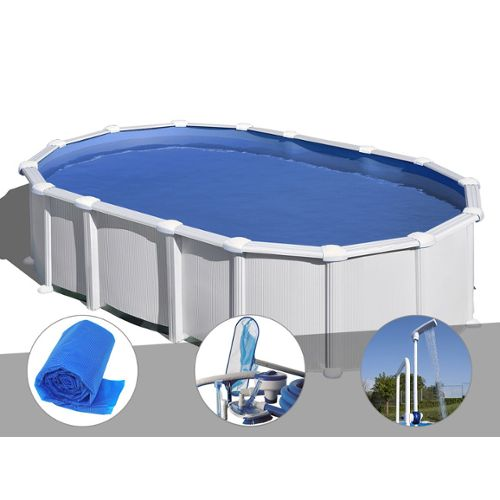

,P_text,P_image,P_final
category,,,
Piscine,0.989,0.898,0.994
Jardin & Bricolage,0.000,0.004,0.002
Jardinage & déco,0.001,0.003,0.001
Sport & Loisirs,0.001,0.003,0.000
Fournitures bureau,0.000,0.005,0.000


,Unnamed: 0,designation,description,productid,imageid,image
66558,66558,Set De Pétanque 6 Boules + Malette Poker En Bois,"Ce Set de 6 boules de Pétanque est fourni dans une malette en bois. Cette malette en bois est idéale pour le rangement ainsi que le transport de votre set de 6 boules de pétanque. Pourvue d'un intérieur en mousse avec compartiments alvéolés cette malette en bois protégera vos boules de pétanque de l'usure. Ce setcontient: 6 boules de pétanque acier chromé 720 gr. Diamètre: 74mm 1 cochonet en bois 1 mallete en bois 1 mètre ruban L'avis de Pokeo ""La pétanque est un jeu d'adresse en plein air largement pratiqué dès l'arrivée des beaux jours. Le but du jeu est enfantin! Sur un terrain de préférence plat tracez un cercle au sol à partir duquel vous lancerez vos boules. Afin de gagner le point vous devez lancer vos boules afin de les placer le plus près possible du cochonnet. En tête à tête ou en équipe de deux (doublettes) ou trois (triplettes) partagez un moment agréable et chaleureux en famille ou entre amis avec ce set de jeu de pétanque.""",798819712,1039577224,

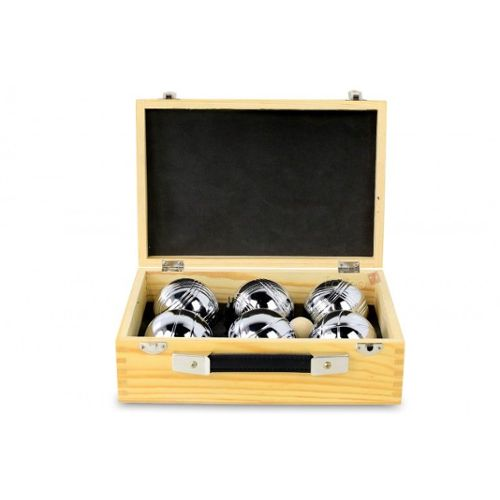

,P_text,P_image,P_final
category,,,
Jeux éducatifs,0.539,0.245,0.633
Sport & Loisirs,0.351,0.019,0.118
Jouets & Figurines,0.031,0.227,0.117
Jeux de rôle,0.010,0.012,0.016
Équipement maison,0.006,0.222,0.010


,Unnamed: 0,designation,description,productid,imageid,image
57173,57173,Xbox 360 Elite (120 Go) Limited Edition Resident Evil 5,NaN,81671673,850117989,

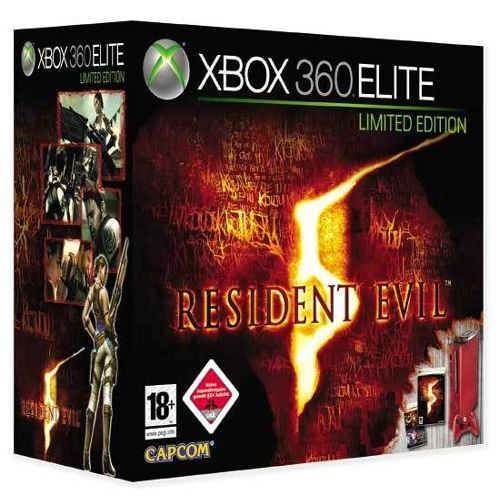

,P_text,P_image,P_final
category,,,
Rétro Gaming,0.099,0.823,0.462
Consoles,0.551,0.024,0.188
Jeux Vidéo,0.273,0.064,0.139
Figurine,0.004,0.003,0.018
Accessoires JV,0.008,0.015,0.017


In [55]:
idx = [0,1,13]


for j, i in enumerate(idx):

    beautiful_print(f"<h3>Exemple {j+1}</h3>")
    display_df_with_images(X_test.iloc[i:i+1])
    
    df_local = pd.DataFrame({
        "P_text": P_test_txt[i],
        "P_image": P_test_im[i],
        "P_final": P_test_final[i],
        "category": categories,
    })

    true_cat = categories[y_test[i]]
    pred_cat = categories[np.argmax(P_test_final[i])]

    beautiful_print(f"""
        <b>Vraie catégorie :</b> {true_cat}<br>
        <b>Catégorie prédite :</b> {pred_cat}
    """, style="secondary")

    display(df_local.sort_values("P_final", ascending=False).set_index('category').round(3).iloc[:5])

<div style="background:#f7fbff; padding:14px; border-radius:6px">

<h4>Analyse qualitative des prédictions multimodales</h4>

<p>
Afin de compléter l’analyse quantitative, quelques exemples représentatifs sont
présentés ci-dessous afin d’illustrer le comportement du modèle multimodal
final, à la fois dans des cas de prédiction correcte et dans des situations
d’erreur. Ces exemples permettent de mieux comprendre la manière dont les
informations textuelles et visuelles sont combinées par le stacking.
</p>

<p>
<b>Exemple 1 – Prédiction correcte.</b><br>
Dans ce premier cas, le produit correspond clairement à la catégorie
<b>Piscine</b>. Le texte est extrêmement descriptif et contient de nombreux
indices explicites (dimensions, volume d’eau, structure, accessoires), ce qui
conduit le modèle texte à une probabilité très élevée. L’image confirme
visuellement cette interprétation. La fusion multimodale renforce encore cette
confiance, aboutissant à une prédiction finale quasi certaine. Cet exemple
illustre un cas idéal où les deux modalités sont cohérentes et se renforcent
mutuellement.
</p>

<p>
<b>Exemple 2 – Erreur liée à une ambiguïté sémantique.</b><br>
Le produit est un <b>set de pétanque</b>, relevant de la catégorie
<b>Sport &amp; Loisirs</b>. Le texte contient cependant des éléments pouvant être
associés à un usage ludique ou familial, ce qui conduit le modèle texte à
favoriser la catégorie <b>Jeux éducatifs</b>. L’image, bien qu’illustrant des
boules de pétanque, n’apporte pas un signal suffisamment discriminant pour
corriger cette confusion. Le modèle final amplifie alors la prédiction issue du
texte. Cette erreur est cohérente avec les confusions observées globalement entre
les catégories <b>Sport &amp; Loisirs</b>, <b>Jeux éducatifs</b> et
<b>Jouets &amp; Figurines</b>, et reflète une zone grise du problème de
classification.
</p>

<p>
<b>Exemple 3 – Erreur liée à un signal visuel dominant.</b><br>
Dans ce troisième exemple, le produit est une <b>console Xbox 360</b>, appartenant
à la catégorie <b>Consoles</b>. L’absence de description textuelle limite fortement
l’apport du texte, tandis que l’image évoque un produit associé à l’univers du
jeu vidéo. Le modèle image attribue alors une forte probabilité à la catégorie
<b>Rétro Gaming</b>, qui domine la fusion finale. Le stacking privilégie ici le
signal visuel, conduisant à une confusion entre des catégories proches d’un point
de vue visuel et fonctionnel. Cette erreur illustre une limite naturelle du
modèle lorsque l’une des modalités est partiellement absente ou peu informative.
</p>

<p>
Dans l’ensemble, ces exemples montrent que les erreurs du modèle multimodal sont
majoritairement <b>interprétables et cohérentes</b> d’un point de vue sémantique.
Elles résultent soit d’ambiguïtés intrinsèques entre catégories proches, soit
d’un déséquilibre d’information entre texte et image. À l’inverse, lorsque les
deux modalités sont riches et cohérentes, la fusion permet d’atteindre des
prédictions très fiables.
</p>

</div>
